# `MonotonicSplineEpistasisGaussianLikelihood` model
Simulates some variants and analyzes them under the `globalepistasis.MonotonicSplineEpistasisGaussianLikelihood` model.

This notebook is designed as a test, not for user documentation--and it uses some private methods that should not be used in real analyses.

## Set up
Import Python modules:

In [1]:
import cProfile
import math
import pstats
import random
import tempfile
import time
import warnings

import numpy

import pandas as pd

from plotnine import *

import scipy

import dms_variants.binarymap
import dms_variants.globalepistasis
import dms_variants.codonvarianttable
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Parameters for simulations:

In [2]:
seed = 1  # random number seed
genelength = 30  # gene length in codons
bclen = 16  # length of barcodes
libs = ['lib_1']  # distinct libraries of gene
variants_per_lib = 1000 * genelength  # variants per library
avgmuts = 2.5  # average codon mutations per variant
variant_error_rate = 0  # rate variants are mis-sequenced
depth = 5000 * variants_per_lib  # per-sample sequencing depth
lib_uniformity = 10  # uniformity of library pre-selection
noise = 0.0  # non-statistical noise in selections
bottlenecks = {  # bottlenecks from pre- to post-selection
        'loose_bottle': variants_per_lib * 10000,
        }

Seed random number generators:

In [3]:
random.seed(seed)
numpy.random.seed(seed)

Suppress warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

Set plotnine theme:

In [5]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate variants
Simulate wildtype gene sequence:

In [6]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 30 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATCCGCAACATCCGGCTG


Simulate a `CodonVariantTable`:

In [7]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={lib: {'avgmuts': avgmuts,
                                     'nvariants': variants_per_lib}
                               for lib in libs},
                seed=seed,
                )

Number of amino-acid mutations per variant in library:

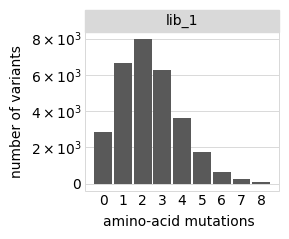

In [8]:
p = variants.plotNumMutsHistogram('aa', samples=None, max_muts=8)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Simulate variant counts
We will simulate using a `SigmoidPhenotypeSimulator`:

In [9]:
phenosimulator = dms_variants.simulate.SigmoidPhenotypeSimulator(
                    geneseq,
                    seed=seed,
                    )

Plot relationship between simulated and observed phenotypes:

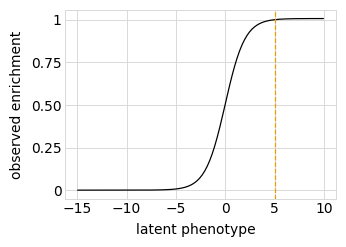

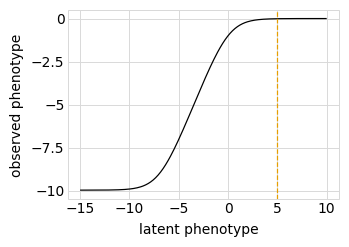

In [10]:
for value in ['enrichment', 'phenotype']:
    p = phenosimulator.plotLatentVsObserved(value)
    _ = p.draw()

Plot latent and observed phenotypes of all single amino-acid mutants:

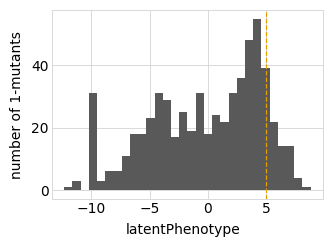

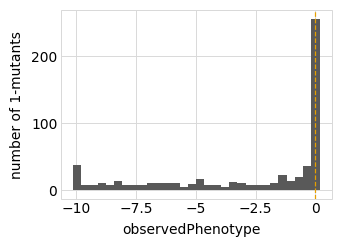

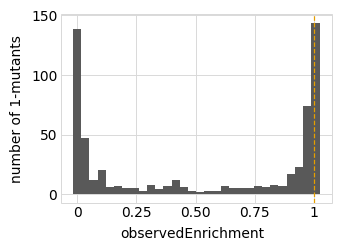

In [11]:
for value in ['latentPhenotype', 'observedPhenotype', 'observedEnrichment']:
    p = phenosimulator.plotMutsHistogram(value)
    _ = p.draw()

Now we simulate the counts according to the observed phenotype:

In [12]:
counts = dms_variants.simulate.simulateSampleCounts(
            variants=variants,
            phenotype_func=phenosimulator.observedEnrichment,
            variant_error_rate=variant_error_rate,
            pre_sample={'total_count': depth,
                        'uniformity': lib_uniformity},
            pre_sample_name='pre-selection',
            post_samples={name: {'noise': noise,
                                 'total_count': depth,
                                 'bottleneck': bottle}
                          for name, bottle in bottlenecks.items()},
            seed=seed,
            )

Add the counts to the variant table:

In [13]:
variants.add_sample_counts_df(counts)

Confirm expected selection on mutations:

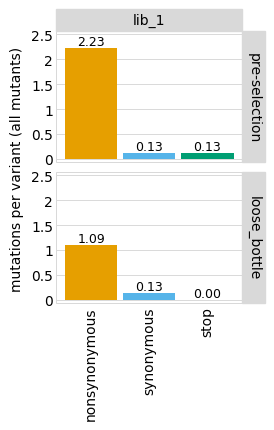

In [14]:
p = variants.plotNumCodonMutsByType('all')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

In [15]:
variants.numCodonMutsByType('all')

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,pre-selection,nonsynonymous,334260460,150000000,2.228403
1,lib_1,pre-selection,synonymous,18909272,150000000,0.126062
2,lib_1,pre-selection,stop,18784796,150000000,0.125232
3,lib_1,loose_bottle,nonsynonymous,164248352,150000000,1.094989
4,lib_1,loose_bottle,synonymous,19198903,150000000,0.127993
5,lib_1,loose_bottle,stop,63622,150000000,0.000424


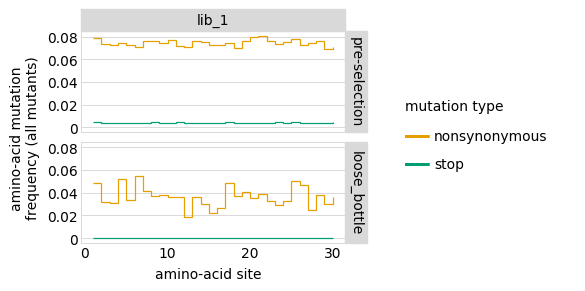

In [16]:
p = variants.plotMutFreqs('all', 'aa')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Get functional scores
Get the functional scores:

In [17]:
func_scores = variants.func_scores('pre-selection')

Classify the functional scores:

In [18]:
func_scores = variants.classifyVariants(func_scores)

Use `plotnine` to plot distribution of functional scores:

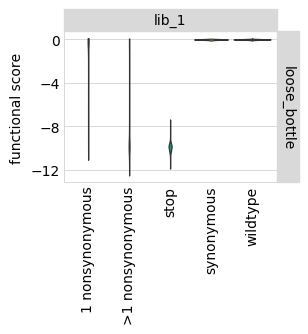

In [19]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('') +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(2.75 * len(libs),
                       2 * len(bottlenecks)),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),  # no vertical grid lines
          ) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

## Initialize model

Make a binary map for the variants:

In [20]:
binarymap = dms_variants.binarymap.BinaryMap(func_scores)
print(f"Length of binary map is {binarymap.binarylength}")

Length of binary map is 600


Now initialize the model:

In [21]:
model = dms_variants.globalepistasis.MonotonicSplineEpistasisGaussianLikelihood(binarymap)

Look at some model attributes:

In [22]:
model.nparams

608

In [23]:
model.likelihood_calc_params_dict

{'epistasis_HOC': 1.0}

In [24]:
round(model.loglik)

-726537.0

In [25]:
model.latent_phenotype_wt()

0.0

In [26]:
for key, val in model.epistasis_func_params_dict.items():
    print(f"{key}: {round(val, 2)}")

c_alpha: 0.0
alpha_1: 0.0
alpha_2: 0.0
alpha_3: 0.0
alpha_4: 0.0
alpha_5: 0.0


Check the analytical gradient versus numerical approximation, and make sure the difference is small compared to total gradient:

In [27]:
err = numpy.optimize.check_grad(
            model._loglik_by_allparams,
            model._dloglik_by_allparams,
            model._allparams)
tot = math.sqrt(sum(model._dloglik_by_allparams(model._allparams)**2))
if err / tot > 1e-5:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

## Fit model
Perform initial least squares optimization followed by rescaling latent effects and epistasis function parameters (normally this is actually performed by the `fit` method):

In [28]:
model._fit_latent_leastsquares()
model._prescale_params(k=1,
                       g_k_range=(binarymap.func_scores.min(),
                                  binarymap.func_scores.max()))

Look at model parameters again:

In [29]:
for key, val in model.epistasis_func_params_dict.items():
    print(f"{key}: {round(val, 2)}")

c_alpha: -12.53
alpha_1: 2.53
alpha_2: 2.53
alpha_3: 2.53
alpha_4: 2.53
alpha_5: 2.53


Re-check the gradients:

In [30]:
err = scipy.optimize.check_grad(
            model._loglik_by_allparams,
            model._dloglik_by_allparams,
            model._allparams)
tot = math.sqrt(sum(model._dloglik_by_allparams(model._allparams)**2))
if err / tot > 1e-3:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

Print model parameters after this "partial" fitting:

In [31]:
round(model.loglik)

-92685.0

In [32]:
for param, val in model.likelihood_calc_params_dict.items():
    print(f"{param}: {val:.3f}")

epistasis_HOC: 5.526


In [33]:
round(model.latent_phenotype_wt(), 3)

0.933

Now fit the model by maximum likelihood, also profiling [as here](https://stackoverflow.com/a/1584468).


In [34]:
# NBVAL_IGNORE_OUTPUT
start = time.time()
profiler = cProfile.Profile()
optres = profiler.runcall(model.fit)
print(f"Fitting took {time.time() - start:.1f} seconds")
print(f"Iterations: {optres.nit}.\n"
      f"Function evaluations: {optres.nfev}\n"
      f"Termination message: {optres.message}")

Fitting took 41.6 seconds
Iterations: 1386.
Function evaluations: 1572
Termination message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Look at some of the model parameters after optimization:

In [35]:
assert numpy.allclose(model.loglik,
                      10007,
                      rtol=0.01,
                      atol=3), model.loglik

In [36]:
assert numpy.allclose(model.likelihood_calc_params_dict['epistasis_HOC'],
                      0.004368,
                      rtol=0.01,
                      atol=0.0005,
                      ), model.likelihood_calc_params_dict['epistasis_HOC']

In [37]:
assert numpy.allclose(model.latent_phenotype_wt(), 0), model.latent_phenotype_wt()

In [38]:
assert numpy.allclose(model._mesh, 
                      numpy.array([-4.05736286, -2.86595888, -1.6745549 , -0.48315092]),
                      atol=0.5,
                      rtol=0.05), model._mesh

In [39]:
assert numpy.allclose(model.alpha_ms(),
                      numpy.array([0, 0, 0, 9.79, 0.112]),
                      atol=0.1,
                      rtol=0.01), model.alpha_ms()

In [40]:
assert numpy.allclose(model.c_alpha(),
                      -9.94,
                      atol=0.1,
                      rtol=0.01), model.c_alpha()

Plot correlation of actual functional scores with latent and observed phenotypes:


Correlation for observed:
R = 1.00, P = 0


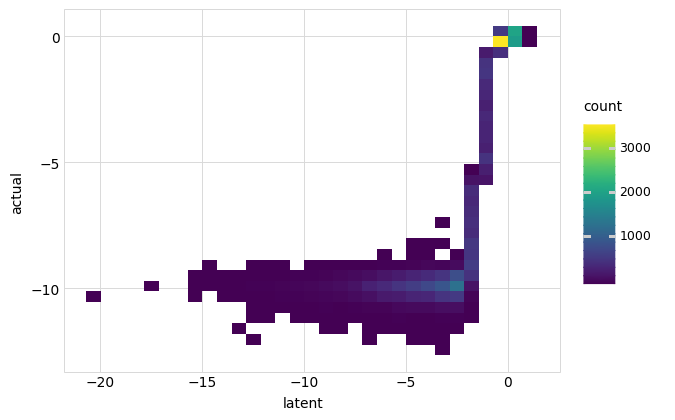

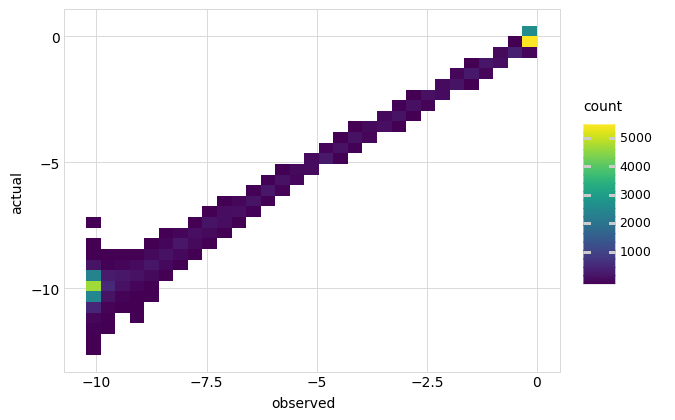

In [41]:
df = pd.DataFrame({'actual': binarymap.func_scores,
                   'latent': model.phenotypes_frombinary(
                                    binarymap.binary_variants, 'latent'),
                   'observed': model.phenotypes_frombinary(
                                    binarymap.binary_variants, 'observed'),
                   })

for phenotype in ['latent', 'observed']:
    _ = (ggplot(df, aes(phenotype, 'actual')) +
         geom_bin2d()
         ).draw()
    
    if phenotype == 'observed':
        r, p = scipy.stats.pearsonr(
            binarymap.func_scores,
                model.phenotypes_frombinary(binarymap.binary_variants,
                                                   phenotype)
            )
        print(f"\nCorrelation for {phenotype}:\nR = {r:.2f}, P = {p:.2g}")

Plot latent versus observed phenotypes:

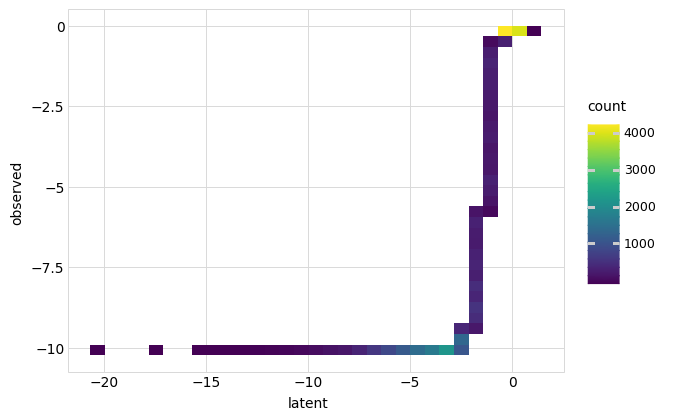

In [42]:
_ = (ggplot(df, aes('latent', 'observed')) +
     geom_bin2d()
     ).draw()

Look at profiling results:

In [43]:
# NBVAL_IGNORE_OUTPUT
with tempfile.NamedTemporaryFile('w') as f:
    profiler.dump_stats(f.name)
    f.flush()
    stats = pstats.Stats(f.name).strip_dirs()
for stat in ['cumtime', 'tottime']:
    print(stats.sort_stats(stat).print_stats(20))

Mon Dec 30 15:15:46 2019    /tmp/tmpyl23j2fu

         9028689 function calls (8306120 primitive calls) in 41.570 seconds

   Ordered by: cumulative time
   List reduced from 336 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   41.570   41.570 globalepistasis.py:1260(fit)
        1    0.000    0.000   41.510   41.510 _minimize.py:42(minimize)
        1    0.214    0.214   41.510   41.510 lbfgsb.py:211(_minimize_lbfgsb)
     1572    0.009    0.000   41.292    0.026 lbfgsb.py:284(func_and_grad)
     4717    1.469    0.000   29.386    0.006 ispline.py:253(_calculate_Itotal_or_dItotal)
    31415    2.266    0.000   26.197    0.001 ispline.py:690(_calculate_I_or_dI)
     1572    0.004    0.000   23.441    0.015 optimize.py:324(function_wrapper)
     1572    0.006    0.000   23.437    0.015 globalepistasis.py:1327(_loglik_by_allparams)
     1574    0.134    0.000   21.193    0.013 globalepistasis.py:1948(logl

## Examine single mutants
Correlation of predicted and actual predicted latent effects.
Get a data frame of the latent effects of all single mutations:

In [44]:
singles_df = model.latent_effects_df

Add the true latent effects from the simulator:

In [45]:
singles_df = (
    singles_df
    .rename(columns={'mutation': 'aa_substitutions'})
    .assign(true_latent_effect=lambda x: x['aa_substitutions'].map(phenosimulator.muteffects))
    )

Now add the predicted and true latent and observed phenotypes:

In [46]:
singles_df = model.add_phenotypes_to_df(singles_df)

singles_df = (
    singles_df
    .assign(true_latent_phenotype=lambda x: x['aa_substitutions']
                                .map(phenosimulator.latentPhenotype),
            true_enrichment=lambda x: x['aa_substitutions']
                                .map(phenosimulator.observedEnrichment),
            true_observed_phenotype=lambda x: x['aa_substitutions']
                                .map(phenosimulator.observedPhenotype),
            enrichment=lambda x: model.enrichments(
                                x['observed_phenotype'])
            )
    )

Correlations among the observed quantities:

In [47]:
print(
 singles_df
 [[c for c in singles_df.columns if 'latent' not in c]]
 .corr()
 .to_csv(float_format='%.1f')
 )

,observed_phenotype,true_enrichment,true_observed_phenotype,enrichment
observed_phenotype,1.0,0.9,1.0,0.9
true_enrichment,0.9,1.0,0.9,1.0
true_observed_phenotype,1.0,0.9,1.0,0.9
enrichment,0.9,1.0,0.9,1.0



## Examine all variants used for fitting
Look at correlation among all the variants used to fit the model:

In [48]:
variants_df = model.phenotypes_df

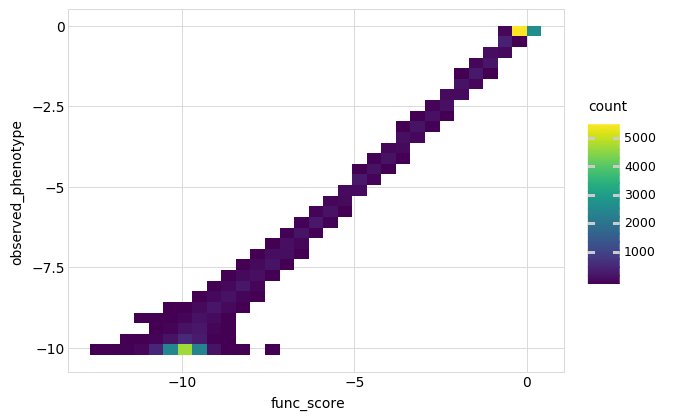

In [49]:
_ = (ggplot(variants_df, aes('func_score', 'observed_phenotype')) + 
     geom_bin2d()
     ).draw()

In [50]:
print(
 variants_df
 [['func_score', 'latent_phenotype', 'observed_phenotype']]
 .corr()
 .to_csv(float_format='%.1f')
 )

,func_score,latent_phenotype,observed_phenotype
func_score,1.0,0.8,1.0
latent_phenotype,0.8,1.0,0.8
observed_phenotype,1.0,0.8,1.0



## Fit multi-latent phenotype model
Now fit a model that allows two latent phenotypes:

In [51]:
model2 = dms_variants.globalepistasis.MonotonicSplineEpistasisGaussianLikelihood(
            binarymap=binarymap,
            n_latent_phenotypes=2,
            model_one_less_latent=model)

Check that this model has the expected number of parameters.
Should be the same as twice the number for the one-latent phenotype model minus one (the house of cards epistasis parameter is shared):

In [52]:
model2.nparams == 2 * model.nparams - 1

True

Initially the log likelihood of the two-latent phenotype model will be the same as the one-latent phenotype model as the values relevant latent effect and epistasis function parameters are all 0:

In [53]:
assert numpy.allclose(model.loglik, model2.loglik)

In [54]:
for key, val in model2.epistasis_func_params_dict.items():
    if key[-2:] == '_2':
        print(f"{key}: {round(val, 2)}")

c_alpha_2: 0.0
alpha_1_2: 0.0
alpha_2_2: 0.0
alpha_3_2: 0.0
alpha_4_2: 0.0
alpha_5_2: 0.0


In [55]:
round(model2.latent_phenotype_wt(k=2), 3)

0.0

Now use private methods (normally called by `fit`) to initialize parameters for the second latent phenotype:

In [56]:
phenos_Kminus1 = list(range(1, model2.n_latent_phenotypes))
residuals = (model2.binarymap.func_scores -
             model2._observed_phenotypes(phenos_Kminus1))
max_abs_residual = numpy.abs(residuals).max()
model2._prescale_params(
                k=model2.n_latent_phenotypes,
                g_k_range=(-max_abs_residual, max_abs_residual))

The log likelihoods should still be the same as the latent effects are all zero and the epistasis function for latent phenotype 2 is set to be 0 for all variants:

In [57]:
assert numpy.allclose(model.loglik, model2.loglik)

In [58]:
for key, val in model2.epistasis_func_params_dict.items():
    if key[-2:] == '_2':
        print(f"{key}: {round(val, 2)}")

c_alpha_2: -2.59
alpha_1_2: 1.04
alpha_2_2: 1.04
alpha_3_2: 1.04
alpha_4_2: 1.04
alpha_5_2: 1.04


In [59]:
round(model2.latent_phenotype_wt(k=2), 3)

0.5

Check the gradient:

In [60]:
err = scipy.optimize.check_grad(
            model2._loglik_by_allparams,
            model2._dloglik_by_allparams,
            model2._allparams)
tot = math.sqrt(sum(model2._dloglik_by_allparams(model2._allparams)**2))
if err / tot > 2e-4:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

Now fit the model (profiling at the same time):

In [61]:
# NBVAL_IGNORE_OUTPUT
start = time.time()
profiler2 = cProfile.Profile()
optres2 = profiler2.runcall(model2.fit)
print(f"Fitting took {time.time() - start:.1f} seconds")
print(f"Iterations: {optres2.nit}.\n"
      f"Function evaluations: {optres2.nfev}\n"
      f"Termination message: {optres2.message}")

Fitting took 161.0 seconds
Iterations: 2140.
Function evaluations: 2434
Termination message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


Look at profiling results:

In [62]:
# NBVAL_IGNORE_OUTPUT
with tempfile.NamedTemporaryFile('w') as f:
    profiler2.dump_stats(f.name)
    f.flush()
    stats2 = pstats.Stats(f.name).strip_dirs()
for stat in ['cumtime', 'tottime']:
    print(stats2.sort_stats(stat).print_stats(20))

Mon Dec 30 15:19:10 2019    /tmp/tmp5m8lhehc

         23261944 function calls (21679155 primitive calls) in 160.994 seconds

   Ordered by: cumulative time
   List reduced from 307 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  160.994  160.994 globalepistasis.py:1260(fit)
        1    0.000    0.000  160.954  160.954 _minimize.py:42(minimize)
        1    0.544    0.544  160.954  160.954 lbfgsb.py:211(_minimize_lbfgsb)
     2434    0.014    0.000  160.403    0.066 lbfgsb.py:284(func_and_grad)
    14607    4.135    0.000  123.651    0.008 ispline.py:253(_calculate_Itotal_or_dItotal)
    73050   12.050    0.000  113.740    0.002 ispline.py:690(_calculate_I_or_dI)
     2434    0.007    0.000   81.580    0.034 optimize.py:324(function_wrapper)
     2434    0.027    0.000   81.573    0.034 globalepistasis.py:1327(_loglik_by_allparams)
     2434    0.047    0.000   78.809    0.032 globalepistasis.py:1355(_

The two-latent phenotype model should have a slightly better log likelihood than the one-latent phenotype model since it has more parameters:

In [63]:
assert model2.loglik > model.loglik

In [64]:
# NBVAL_IGNORE_OUTPUT

if model2.loglik > model.loglik:
    print(f"Two-latent model has better loglik ({round(model2.loglik)}) than "
          f"one-latent model ({round(model.loglik)}) as expected")
else:
    raise ValueError(f"Two-latent model has worse loglik ({round(model2.loglik)}) than "
                     f"one-latent model ({round(model.loglik)})")

Two-latent model has better loglik (15936.0) than one-latent model (10007.0) as expected


Look at correlation of observed phenotype with functional score for the two-latent phenotype model, and also tabulate correlation of each observed and latent phenotype with functional score:

In [65]:
variants_df2 = model2.phenotypes_df

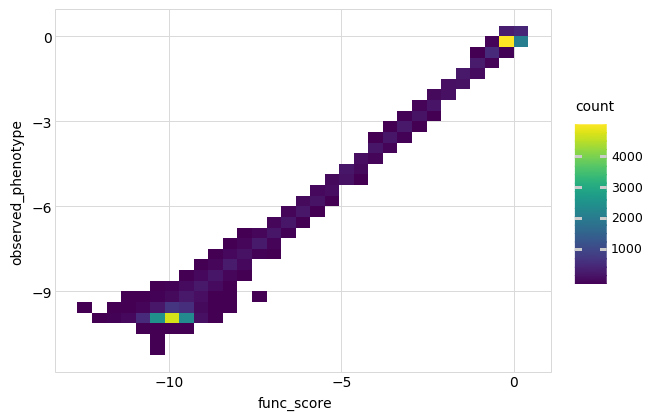

In [66]:
_ = (ggplot(variants_df2, aes('func_score', 'observed_phenotype')) + 
     geom_bin2d()
     ).draw()

Plot the distribution of single-mutant effects on each latent phenotype:

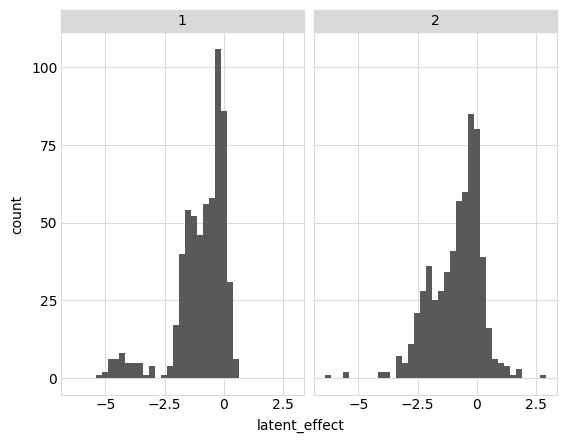

In [68]:
_ = (ggplot(model2.latent_effects_df,
            aes('latent_effect')) +
     geom_histogram() +
     facet_wrap('latent_phenotype_number')
     ).draw()

Plot relationship of latent and observed phenotype for each latent phenotype.
As expected, the second latent phenotype looks is noisier as there is really only one latent phenotype in the simulated data:

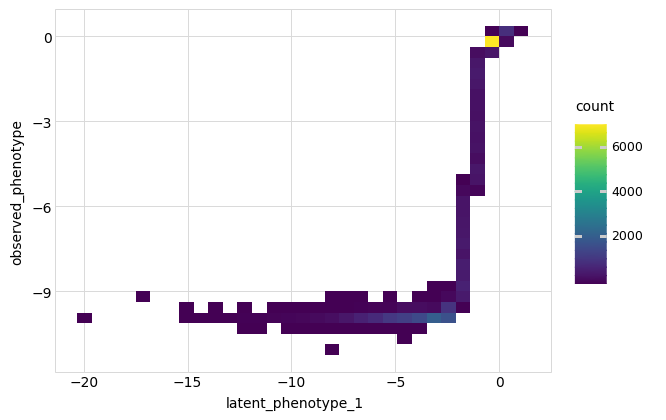

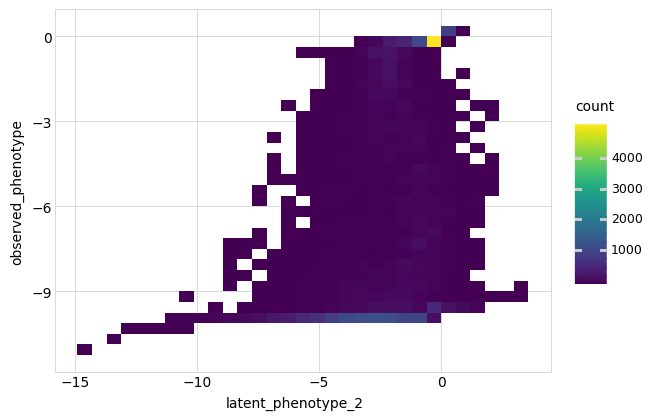

In [69]:
for k in [1, 2]:
    _ = (ggplot(model2.phenotypes_df, aes(f"latent_phenotype_{k}", 'observed_phenotype')) +
         geom_bin2d()
         ).draw()

Look at the epistasis function parameters:

In [70]:
# NBVAL_IGNORE_OUTPUT

for param, val in model2.epistasis_func_params_dict.items():
    print(f"{param}: {val:.1g}")

c_alpha_1: -9
alpha_1_1: 1e-08
alpha_2_1: 1e-08
alpha_3_1: 1e-08
alpha_4_1: 1e+01
alpha_5_1: 0.1
c_alpha_2: -2
alpha_1_2: 2
alpha_2_2: 0.02
alpha_3_2: 2e-05
alpha_4_2: 1
alpha_5_2: 1
